In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.manifold import TSNE

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

In [477]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10, l_size=392, init_fn=nn.init.kaiming_normal_):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, l_size)
        init_fn(self.fc1.weight)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(l_size, latent_size)
        init_fn(self.fc2.weight)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = torch.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10, l_size=392, init_fn=nn.init.xavier_uniform_):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, l_size)
        init_fn(self.fc1.weight)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(l_size, 28*28)
        init_fn(self.fc2.weight)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = torch.tanh(self.fc2(x))
        return x

In [478]:
class Net(nn.Module):
    def __init__(self, latent_size=10, l_size=392, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.l_size = l_size       
        self.E = Encoder(latent_size, l_size)
        self.D = Decoder(latent_size, l_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def encode(self, x):
        with torch.no_grad():
            x = x.view(-1, 28*28)
            return self.E(x)
        
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [479]:
def add_noise(x, mode='crop', elementwise=False):
#     if np.random.randint(2):
#         return x
    x = x.clone()
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2)*2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            img_part = np.random.randint(4)
            if img_part == 0:
                x[:, :, :28, 14:] = torch.tensor(x[:, :, :28, :14].numpy()[:, :, :, ::-1].copy())
            elif img_part == 1:
                x[:, :, :28, :14] = torch.tensor(x[:, :, :28, 14:].numpy()[:, :, :, ::-1].copy())
            elif img_part == 2:
                x[:, :, 14:, :28] = torch.tensor(x[:, :, :14, :28].numpy()[:, :, ::-1, :].copy())
            elif img_part == 3:
                x[:, :, :14, :28] = torch.tensor(x[:, :, 14:, :28].numpy()[:, :, ::-1, :].copy())
        
        elif mode == 'gaussian':
            noise = nn.Parameter(x.new(x.size()).normal_())
            x = x + noise*0.1
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2)*2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
    return x

In [480]:
def train(epoch, models, log=None, mode='crop', elementwise=False):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noized = add_noise(data, mode=mode, elementwise=elementwise)
        for model in models.values():
            model.optim.zero_grad()
            output = model(noized)
            loss = model.loss(output, data)
            loss.backward(retain_graph=True)
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [481]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)

def test(models, loader, log=None, mode='crop', elementwise=False):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            noized = add_noise(data, mode=mode, elementwise=elementwise)
            output = {k: m(noized) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

### Models

In [482]:
models = {'2_392': Net(latent_size=2, l_size=392),
          '32_392': Net(latent_size=32, l_size=392),
          '2_1568': Net(latent_size=2, l_size=1568),
          '32_1568': Net(latent_size=32, l_size=1568)}

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [483]:
models

{'2_392': Net(
   (E): Encoder(
     (fc1): Linear(in_features=784, out_features=392, bias=True)
     (relu1): ReLU()
     (fc2): Linear(in_features=392, out_features=2, bias=True)
   )
   (D): Decoder(
     (fc1): Linear(in_features=2, out_features=392, bias=True)
     (relu1): ReLU()
     (fc2): Linear(in_features=392, out_features=784, bias=True)
   )
 ), '32_392': Net(
   (E): Encoder(
     (fc1): Linear(in_features=784, out_features=392, bias=True)
     (relu1): ReLU()
     (fc2): Linear(in_features=392, out_features=32, bias=True)
   )
   (D): Decoder(
     (fc1): Linear(in_features=32, out_features=392, bias=True)
     (relu1): ReLU()
     (fc2): Linear(in_features=392, out_features=784, bias=True)
   )
 ), '2_1568': Net(
   (E): Encoder(
     (fc1): Linear(in_features=784, out_features=1568, bias=True)
     (relu1): ReLU()
     (fc2): Linear(in_features=1568, out_features=2, bias=True)
   )
   (D): Decoder(
     (fc1): Linear(in_features=2, out_features=1568, bias=True)
     (r

# CROP
- latent_size = 2 | 32
- l_size = 392 | 1568
- ementwise = False
- mode = crop

In [484]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log, mode='crop', elementwise=False)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log, mode='crop', elementwise=False)

Train Epoch: 1 [00000/60000] 2_392: 0.985934 32_392: 0.934106 2_1568: 1.030392 32_1568: 0.943234
Train Epoch: 1 [30000/60000] 2_392: 0.341168 32_392: 0.282763 2_1568: 0.278124 32_1568: 0.272356
Train Epoch: 1 [60000/60000] 2_392: 0.294633 32_392: 0.279130 2_1568: 0.280514 32_1568: 0.260710
Test set:
2_392: loss: 0.2868
32_392: loss: 0.2698
2_1568: loss: 0.2717
32_1568: loss: 0.2514

Train Epoch: 2 [00000/60000] 2_392: 0.290543 32_392: 0.272484 2_1568: 0.275255 32_1568: 0.253761
Train Epoch: 2 [30000/60000] 2_392: 0.273541 32_392: 0.254764 2_1568: 0.263621 32_1568: 0.226737
Train Epoch: 2 [60000/60000] 2_392: 0.268163 32_392: 0.235121 2_1568: 0.256398 32_1568: 0.199518
Test set:
2_392: loss: 0.2725
32_392: loss: 0.2389
2_1568: loss: 0.2599
32_1568: loss: 0.2048

Train Epoch: 3 [00000/60000] 2_392: 0.274902 32_392: 0.237803 2_1568: 0.262117 32_1568: 0.205943
Train Epoch: 3 [30000/60000] 2_392: 0.259729 32_392: 0.208045 2_1568: 0.248477 32_1568: 0.171515
Train Epoch: 3 [60000/60000] 2_392

In [583]:
losses_df = pd.DataFrame(columns=['mode', 'elementwise', 'fc1(.., l_size)', 'fc2(.., latent_size)', 'test loss'])

losses_df['fc1(.., l_size)'] = [392, 392, 1568, 1568]
losses_df['fc2(.., latent_size)'] = [2, 32, 2, 32]
losses_df['mode'].fillna('Crop', inplace=True)
losses_df['elementwise'].fillna('False', inplace=True)

losses_df['test loss'] = [0.2234, 0.1102, 0.2220, 0.0922]
losses_df

,mode,elementwise,"fc1(.., l_size)","fc2(.., latent_size)",test loss
0,Crop,False,392,2,0.2234
1,Crop,False,392,32,0.1102
2,Crop,False,1568,2,0.2220
3,Crop,False,1568,32,0.0922


### Noised

MODEL 2_392 Raw data


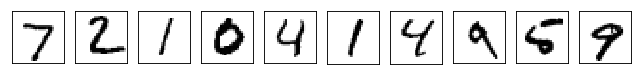

MODEL 2_392 Mirror


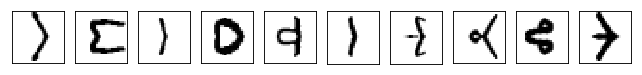

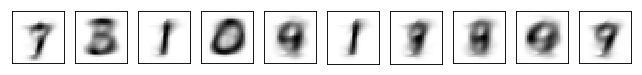

MODEL 2_392 Gaussian


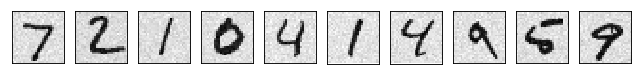

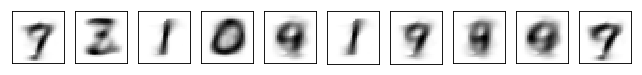

MODEL 2_392 Elementwise crop


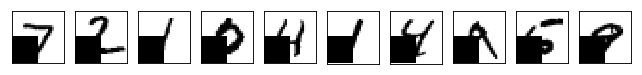

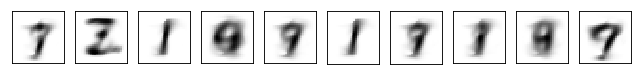

MODEL 2_392 Not elementwise crop


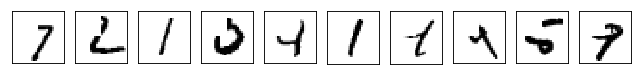

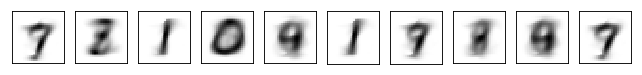

MODEL 32_392 Raw data


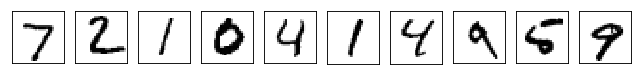

MODEL 32_392 Mirror


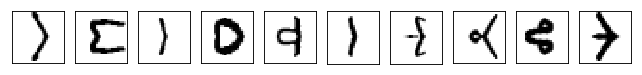

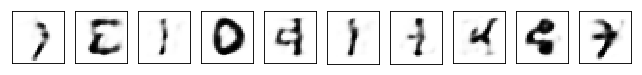

MODEL 32_392 Gaussian


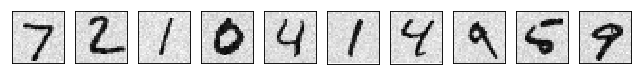

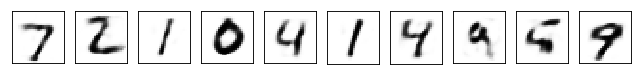

MODEL 32_392 Elementwise crop


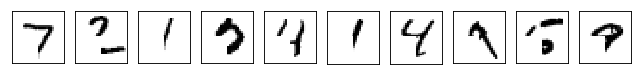

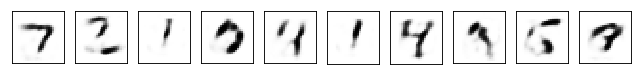

MODEL 32_392 Not elementwise crop


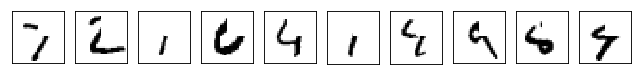

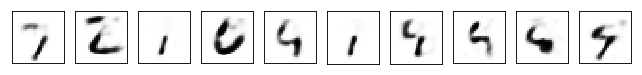

MODEL 2_1568 Raw data


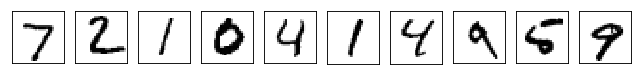

MODEL 2_1568 Mirror


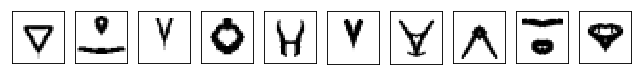

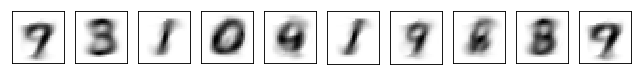

MODEL 2_1568 Gaussian


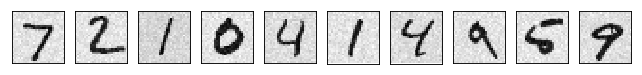

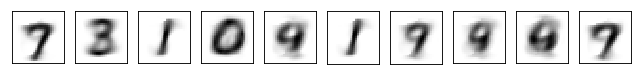

MODEL 2_1568 Elementwise crop


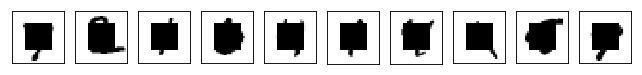

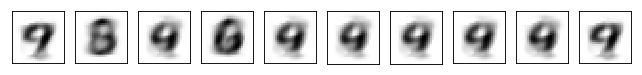

MODEL 2_1568 Not elementwise crop


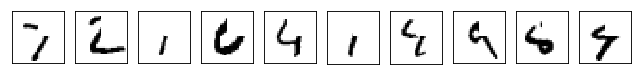

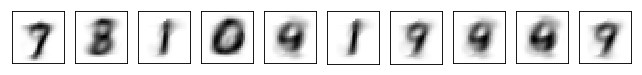

MODEL 32_1568 Raw data


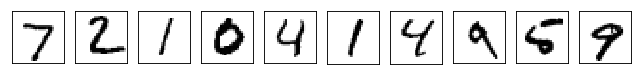

MODEL 32_1568 Mirror


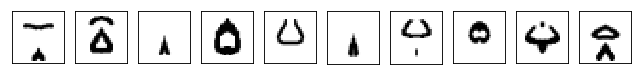

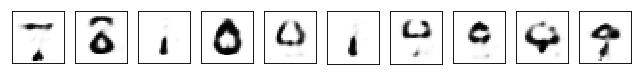

MODEL 32_1568 Gaussian


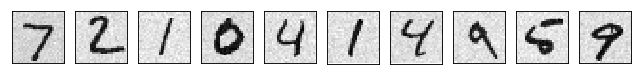

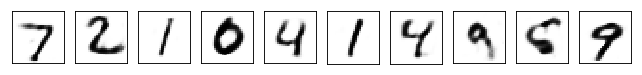

MODEL 32_1568 Elementwise crop


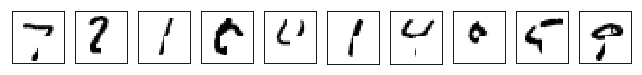

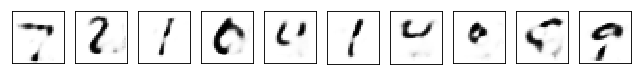

MODEL 32_1568 Not elementwise crop


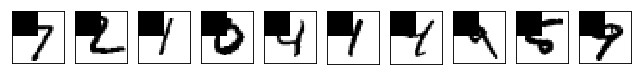

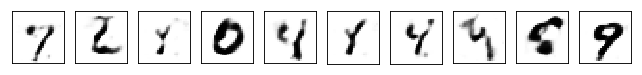

In [592]:
for m in models:
    print('MODEL', m, 'Raw data')
    data, _ = next(iter(test_loader))
    plot_mnist(data.data.numpy()[:10], (1, 10))

    
    print('MODEL', m, 'Mirror')
    noized = add_noise(data, mode='mirror', elementwise=True)
    plot_mnist(noized[:10], (1, 10))

    output = models[m](noized[:10])
    to_plot = output.view(-1, 1, 28, 28).data.numpy()
    plot_mnist(to_plot, (1, 10))

    
    print('MODEL', m, 'Gaussian')
    noized = add_noise(data, mode='gaussian', elementwise=True).detach()
    plot_mnist(noized[:10], (1, 10))

    output = models[m](noized[:10])
    to_plot = output.view(-1, 1, 28, 28).data.numpy()
    plot_mnist(to_plot, (1, 10))

    
    print('MODEL', m, 'Elementwise crop')
    noized = add_noise(data, mode='crop', elementwise=False)
    plot_mnist(noized[:10], (1, 10))

    output = models[m](noized[:10])
    to_plot = output.view(-1, 1, 28, 28).data.numpy()
    plot_mnist(to_plot, (1, 10))

    
    print('MODEL', m, 'Not elementwise crop')
    noized = add_noise(data, mode='crop', elementwise=False)
    plot_mnist(noized[:10], (1, 10))

    output = models[m](noized[:10])
    to_plot = output.view(-1, 1, 28, 28).data.numpy()
    plot_mnist(to_plot, (1, 10))

In [487]:
cmap = {'black': '#000000',
        'yellow': '#ffe119',
        'magneta': '#f032e6',
        'green': '#3cb44b',
        'blue': '#4363d8',
        'gray': '#a9a9a9',
        'cyan': '#42d4f4',
        'red': '#e6194B',
        'lime': '#bfef45',
        'orange': '#f58231'}

colors = dict(zip([float(i) for i in range(10)], [j for i, j in enumerate(cmap.values())]))

In [488]:
train_loader_to_plot, test_loader_to_plot = mnist(batch_size=10000, valid=0, transform=mnist_transform)
plot_data, _ = next(iter(test_loader_to_plot))
test_loader_to_plot.dataset.data.size()

torch.Size([10000, 28, 28])

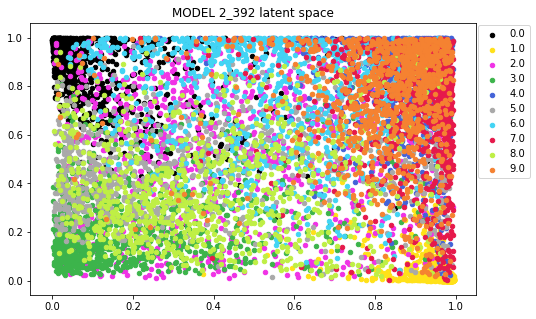

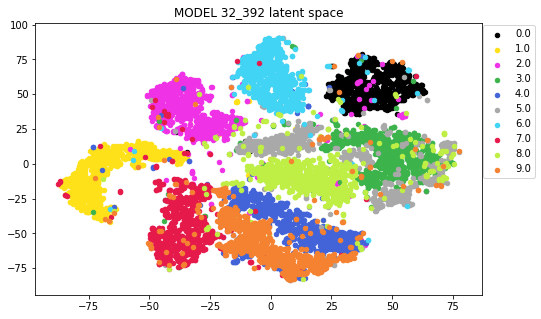

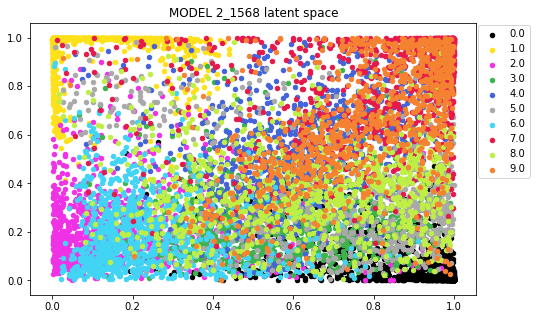

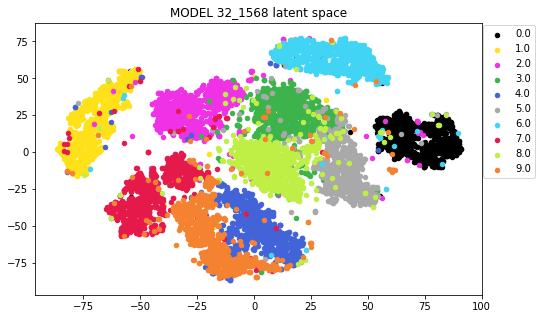

In [489]:
dots_amount=10000
for m in models:
#     X = models[m].encode(data[:dots_amount, :, :, :])
    X = models[m].encode(plot_data[:dots_amount])
    if m[:1] != '2':
        X = TSNE(n_components=2, random_state=0).fit_transform(X)
    x = [float(i[0]) for i in X]
    y = [float(i[1]) for i in X]
#     l = train_loader.dataset.targets[:dots_amount].numpy()
    l = test_loader_to_plot.dataset.targets[:dots_amount].numpy()

    latent_code = pd.DataFrame([x, y, l]).T.sort_values(2).reset_index(drop=True)
    latent_code.columns = ['x', 'y', 'label']

    fig, ax = plt.subplots(figsize=(8,5))
    for i in latent_code['label'].unique():
        df = latent_code[latent_code['label']==i]
        ax.scatter(df['x'], df['y'], color=colors[i], s=20, label=i)
    plt.legend(bbox_to_anchor=(0.63, 0.51, 0.5, 0.5))
    plt.title('MODEL {} latent space'.format(m))

# MIRROR
- latent_size = 2 | 32
- l_size = 392 | 1568
- ementwise = True
- mode = mirror

In [490]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log, mode='mirror', elementwise=True)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log, mode='mirror', elementwise=True)

Train Epoch: 1 [00000/60000] 2_392: 0.227366 32_392: 0.174882 2_1568: 0.224968 32_1568: 0.171750
Train Epoch: 1 [30000/60000] 2_392: 0.219713 32_392: 0.148649 2_1568: 0.219439 32_1568: 0.133432
Train Epoch: 1 [60000/60000] 2_392: 0.227103 32_392: 0.165182 2_1568: 0.229269 32_1568: 0.151552
Test set:
2_392: loss: 0.2249
32_392: loss: 0.1539
2_1568: loss: 0.2266
32_1568: loss: 0.1397

Train Epoch: 2 [00000/60000] 2_392: 0.229353 32_392: 0.146797 2_1568: 0.231641 32_1568: 0.130633
Train Epoch: 2 [30000/60000] 2_392: 0.227726 32_392: 0.143731 2_1568: 0.227418 32_1568: 0.128195
Train Epoch: 2 [60000/60000] 2_392: 0.227253 32_392: 0.154132 2_1568: 0.229384 32_1568: 0.143075
Test set:
2_392: loss: 0.2240
32_392: loss: 0.1484
2_1568: loss: 0.2252
32_1568: loss: 0.1339

Train Epoch: 3 [00000/60000] 2_392: 0.218167 32_392: 0.151909 2_1568: 0.218706 32_1568: 0.135773
Train Epoch: 3 [30000/60000] 2_392: 0.214549 32_392: 0.141655 2_1568: 0.213353 32_1568: 0.124492
Train Epoch: 3 [60000/60000] 2_392

In [584]:
losses_df2 = pd.DataFrame(columns=['mode', 'elementwise', 'fc1(.., l_size)', 'fc2(.., latent_size)', 'test loss'])

losses_df2['fc1(.., l_size)'] = [392, 392, 1568, 1568]
losses_df2['fc2(.., latent_size)'] = [2, 32, 2, 32]
losses_df2['mode'].fillna('Mirror', inplace=True)
losses_df2['elementwise'].fillna('True', inplace=True)

losses_df2['test loss'] = [0.2172, 0.1252, 0.2149, 0.1101]
losses_df = pd.concat([losses_df, losses_df2], axis=0)

# GAUSSIAN
- latent_size = 2 | 32
- l_size = 392 | 1568
- ementwise = True
- mode = gaussian

In [492]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log, mode='gaussian', elementwise=True)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log, mode='gaussian', elementwise=True)

Train Epoch: 1 [00000/60000] 2_392: 0.213705 32_392: 0.098996 2_1568: 0.211392 32_1568: 0.080551
Train Epoch: 1 [30000/60000] 2_392: 0.207241 32_392: 0.073095 2_1568: 0.205440 32_1568: 0.055610
Train Epoch: 1 [60000/60000] 2_392: 0.214293 32_392: 0.074541 2_1568: 0.210967 32_1568: 0.056215
Test set:
2_392: loss: 0.2129
32_392: loss: 0.0722
2_1568: loss: 0.2100
32_1568: loss: 0.0543

Train Epoch: 2 [00000/60000] 2_392: 0.209067 32_392: 0.072573 2_1568: 0.205330 32_1568: 0.055210
Train Epoch: 2 [30000/60000] 2_392: 0.211758 32_392: 0.071141 2_1568: 0.208521 32_1568: 0.054197
Train Epoch: 2 [60000/60000] 2_392: 0.214685 32_392: 0.069709 2_1568: 0.211783 32_1568: 0.051565
Test set:
2_392: loss: 0.2123
32_392: loss: 0.0673
2_1568: loss: 0.2094
32_1568: loss: 0.0502

Train Epoch: 3 [00000/60000] 2_392: 0.216297 32_392: 0.068123 2_1568: 0.213991 32_1568: 0.050748
Train Epoch: 3 [30000/60000] 2_392: 0.203569 32_392: 0.063735 2_1568: 0.199557 32_1568: 0.046578
Train Epoch: 3 [60000/60000] 2_392

In [ ]:
losses_df2 = pd.DataFrame(columns=['mode', 'elementwise', 'fc1(.., l_size)', 'fc2(.., latent_size)', 'test loss'])

losses_df2['fc1(.., l_size)'] = [392, 392, 1568, 1568]
losses_df2['fc2(.., latent_size)'] = [2, 32, 2, 32]
losses_df2['mode'].fillna('Gaussian', inplace=True)
losses_df2['elementwise'].fillna('True', inplace=True)

losses_df2['test loss'] = [0.2070, 0.0428, 0.2006, 0.0321]
losses_df = pd.concat([losses_df, losses_df2], axis=0).reset_index(drop=True)

# Result

In [588]:
losses_df.at[losses_df[losses_df['mode']=='Crop'].index, 'color'] = '#B576AD'
losses_df.at[losses_df[losses_df['mode']=='Mirror'].index, 'color'] = '#B7D968'
losses_df.at[losses_df[losses_df['mode']=='Gaussian'].index, 'color'] = '#7CCCE5'

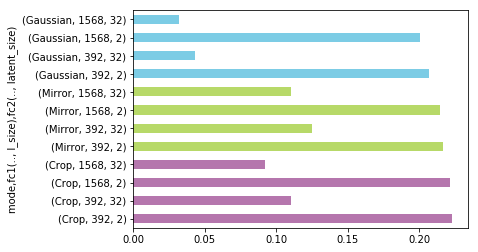

In [589]:
losses_df.set_index(['mode',
                     'fc1(.., l_size)',
                     'fc2(.., latent_size)'])['test loss'].plot(kind='barh', color=losses_df['color'])

In [591]:
pd.concat([losses_df[losses_df['test loss']==losses_df['test loss'].max()],
           losses_df[losses_df['test loss']==losses_df['test loss'].min()]], axis=0).drop('color', axis=1)

,mode,elementwise,"fc1(.., l_size)","fc2(.., latent_size)",test loss
0,Crop,False,392,2,0.2234
11,Gaussian,True,1568,32,0.0321


# Карты активаций нейронов первого слоя

In [506]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [510]:
X_test, y_test = next(iter(test_loader))

In [512]:
models['2_1568'].E.fc1.register_forward_hook(get_activation('fc1'))

In [501]:
data, _ = next(iter(train_loader))
data.unsqueeze_(0)
output = models['2_1568'](data)
act = activation['fc1'].squeeze()

torch.Size([200, 1568])

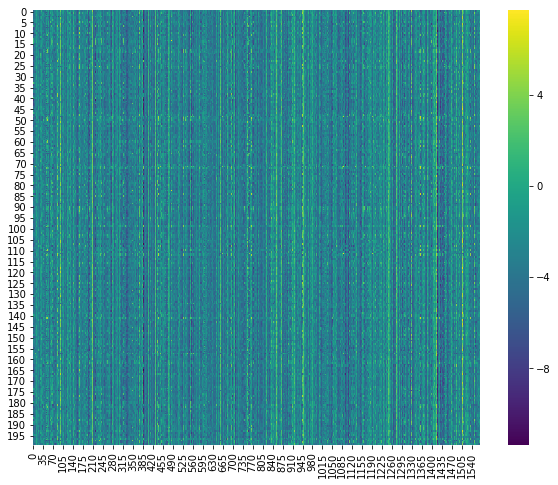

In [523]:
plt.figure(figsize=(10, 8))
sns.heatmap(act, cmap='viridis')
act.size()